In [1]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import processing_funcs as pf
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd

# added to show plots in the notebook
%matplotlib inline

# empty lists that will be filled by the relevent steps
node_list = []
way_list = []
way_tag_list = []
node_tag_list = []
way_node_list = []

# Dictionary to help iterate through the csv generation step
cvs_dict = {
    "nodes.csv": node_list, 
    "ways.csv": way_list,
    "way_tags.csv": way_tag_list, 
    "node_tags.csv": node_tag_list, 
    "way_node_connections.csv": way_node_list
}

# Get the path of the xml file and open it
cwd = os.getcwd()
mapfile = cwd + "/gordon_county.xml"
map_file_open = open(mapfile, "rb")

def populate_parent_list(tag_type, tag_type_list, values, parent):
    # Force correct types on all data, this will avoid need to validate vs the schema
    tag_type['id'] = int(values['id'])
    if parent == "node":
        tag_type['lat'] = float(values['lat'])
        tag_type['lon'] = float(values['lon'])
    tag_type['user'] = str(values['user'])
    tag_type['uid'] = int(values['uid'])
    tag_type['version'] = str(values['version'])
    tag_type['changeset'] = int(values['changeset'])
    tag_type['timestamp'] = str(values['timestamp'])
    tag_type_list.append(tag_type)

    
def populate_parent_list(tag_type, tag_type_list, values, parent):
    # Force correct types on all data, this will avoid need to validate vs the schema
    tag_type['id'] = int(values['id'])
    if parent == "node":
        tag_type['lat'] = float(values['lat'])
        tag_type['lon'] = float(values['lon'])
    tag_type['user'] = str(values['user'])
    tag_type['uid'] = int(values['uid'])
    tag_type['version'] = str(values['version'])
    tag_type['changeset'] = int(values['changeset'])
    tag_type['timestamp'] = str(values['timestamp'])
    tag_type_list.append(tag_type)


## OpenStreetMap Case Study

### Chosen Area
Gordon County, Georgia, US - https://www.openstreetmap.org/relation/1020717

I chose this area because it is where I have lived for the last 14 years. I wanted to find out some of the statistics on it.

### Problems Encountered
While the overall data quality was not horrible, I did encounter the following issues:
* Abbreviated directions and street types (i.e. NE, W, St, Ln, etc)
* Multiple values combined with various punctuations in a single value tag, this made it harder to check for issues (i.e. NE:SW, 30733;30734, etc)
* Multiple fields with "problem characters"

#### Problems addressed

The problems above were solved in the following code blocks:

This code block created the dictionary needed to swap the correct values for each abbreviation

In [2]:
# List of abbreviations that will need to be swapped to the full word
subs = {
    "Ln": "Lane",
    "Rd": "Road",
    "Dr": "Drive", 
    "Trl": "Trail",
    "Ct": "Court",
    "Ave": "Avenue",
    "St": "Street",
    "Pl": "Place",
    "Hwy": "Highway",
    "N": "North",
    "W": "West",
    "S": "South",
    "E": "East",
    "NE": "Northeast",
    "NW": "Northwest",
    "SE": "Southeast",
    "SW": "Southwest",
    "GA": "Georgia",
    " GA": " Georgia",
    "Ga": "Georgia"
}

This code block used the Udacity provided regex expression to check each tag's key value. The tag was dicarded if it contained a problem character. If it did not contain any problem characters it was passed to the populate_parent_tag_list function.

In [3]:
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# Iterate through all of the tags fields in the xml file
for event, elem in ET.iterparse(map_file_open, events=("start",)):

    if elem.tag == "node":
        # Set the empty disctionary for the node
        node = {}
        pf.populate_parent_list(node, node_list, elem.attrib, elem.tag)

        # Node tags needed: id, key, value, type
        for tag in elem.iter("tag"):  
            
            # If the tag is a "tag", then skip it if it has problem characters, or add it to the node_tag_list
            if PROBLEMCHARS.search(tag.attrib['k']):
                print(tag.attrib['k'])
                continue
            else:            
                node_tag = {}
                pf.populate_parent_tag_list(node_tag, node_tag_list, tag.attrib, node, subs) 

    if elem.tag == "way":
        # Set the empty dictionaries for the way and the "way + node " relation
        way = {}
        way_node = {}
        pf.populate_parent_list(way, way_list, elem.attrib, elem.tag)

        # Set a counter for the "nd" tags, as this will mark their position
        counter = 0

        # Cycle through the child tags under the "way"
        for tag in elem:

            # if the tag is a nd, process it and add it to the way_node_list
            if tag.tag == "nd":  
                way_node = {}
                way_node['id'] = int(way['id'])
                way_node['node_id'] = int(tag.attrib['ref'])
                way_node['position'] = int(counter)
                way_node_list.append(way_node)
                counter += 1

            # If the tag is a "tag", then skip it if it has problem characters, or add it to the way_tag_list
            if tag.tag == "tag": 
                if PROBLEMCHARS.search(tag.attrib['k']):
                    print(tag.attrib['k'])
                    continue
                else:                        
                    way_tag = {}     
                    pf.populate_parent_tag_list(way_tag, way_tag_list, tag.attrib, way, subs)     


In regards to the problems addressed, this function checked singular values against the subs dictionary, and sent values combined by punctuation to the spilit_values function for further processing.  


In [4]:
def populate_parent_tag_list(tag_type, tag_type_list, values, parent, subs_list):
    # Force correct types on all data, this will avoid need to validate vs the schema
    tag_type['id'] = int(parent['id'])
    tag_type['key'] = str(values['k'])
    tag_type['value'] = ""
    tag_type['type'] = "default"

    # swap bad abbreviations, get rid of bad characters, remove overlapping info
    cleaned_value_tag = ""
    if ":" in values['v']:
        tag_type['value'] = split_values(values['v'], ":", subs_list)
    elif "," in values['v']:
        tag_type['value'] = split_values(values['v'], ",", subs_list)
    elif ";" in values['v']:
        tag_type['value'] = split_values(values['v'], ";", subs_list)
    else:
        if values['v'] in subs_list.keys():
            cleaned_value_tag = subs_list.get(values['v'])
            tag_type['value'] = str(cleaned_value_tag)
        else:
            tag_type['value'] = values['v']

    # Sort out the types and keys
    if ":" in values['k']:
        split_tag = values['k'].split(":")
        if len(split_tag) > 2:
            tag_type['type'] = str(split_tag[0])
            tag_type['key'] = ":".join(split_tag[1:])
        else:
            tag_type['type'] = str(split_tag[0])
            tag_type['key'] = str(split_tag[1])
    else:
        tag_type['key'] = str(values['k'])
    tag_type_list.append(tag_type)

This function checked the now split values against the subs dictionary to make sure all unaccepted abbreviations were swapped for correct values

In [5]:
def split_values(values_to_split, character_to_split, subs_list):
    # Split up the values that have certain characters, check them vs the abbrevication list, 
    # and join them back together once fixed or cleared
    temp_list = values_to_split.split(character_to_split)
    new_list = []
    for temp_value in temp_list:
        if temp_value in subs_list.keys():
            new_list.append(str(subs_list.get(temp_value)))
        else:
            new_list.append(str(temp_value))
    cleaned_value_tag_list = character_to_split.join(new_list)
    return cleaned_value_tag_list

In [6]:
map_file_open.close()

# Data Overview

## The original file:
Format: OSM XML
Size: 76.9 MB
Length: 1.25m lines

## The database:

In [7]:
import mysql.connector

db = mysql.connector.connect(
  host="localhost",
  user="jasonk",
  password="password123",
  database="openstreetmap"
)


### Basic Stats

In [8]:
# Find database size
# reference: https://stackoverflow.com/questions/1733507/how-to-get-size-of-mysql-database
cursor = db.cursor()
sql = "SELECT SUM(ROUND(((DATA_LENGTH + INDEX_LENGTH) / 1024 / 1024), 2)) AS \
    'SIZE IN MB' FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'openstreetmap';"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(Decimal('104.72'),)


The Size of the Database is 104.72 MB 

In [9]:
# Find total unique users
# reference: https://dba.stackexchange.com/questions/87412/count-multiple-tables-as-one-count
cursor = db.cursor()
sql = "SELECT COUNT(DISTINCT total.uid) FROM(SELECT uid_node as uid from nodes UNION ALL SELECT uid_way as uid from ways \
    ) total"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(527,)


There are 527 unique users who contributed to the dataset

In [10]:
# Find total ways and nodes combined
cursor = db.cursor()
sql = "SELECT SUM(total.count) FROM(SELECT COUNT(*) as count from ways UNION ALL \
    SELECT COUNT(*) as count from nodes) total"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)
    
cursor = db.cursor()
sql = "SELECT COUNT(*) as count from nodes"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)
    
cursor = db.cursor()
sql = "SELECT COUNT(*) as count from ways"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(Decimal('344831'),)
(330922,)
(13909,)


There are 344,831 combined ways and nodes  
There are 330922 nodes  
There are 13909 ways  

### Analytic inspections

My first investigative query was to check which sers contributed the most.

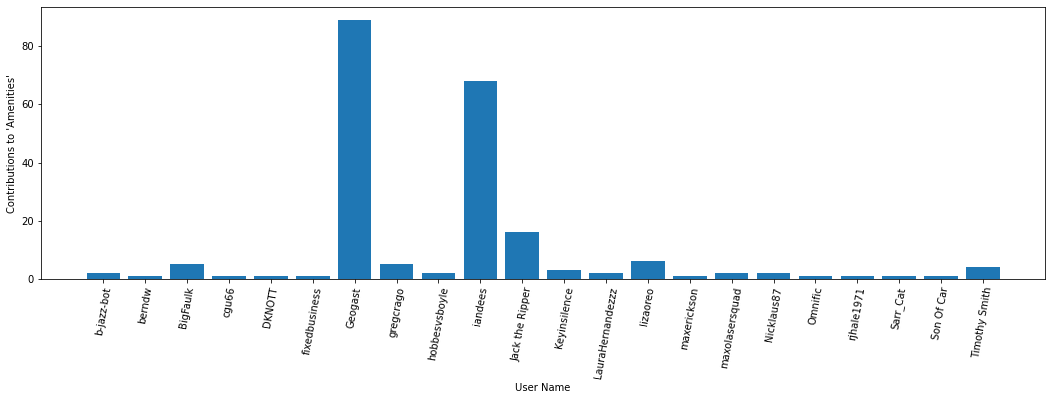

In [12]:
filename = "user_totals.csv"
user_totals_df = pd.read_csv(filename)
plt.figure(figsize=(18, 5))
plt.bar(user_totals_df['node_user'], user_totals_df['total'])
plt.xticks(rotation = 80)
plt.xlabel("User Name")
plt.ylabel("Contributions to 'Amenities'")
plt.show()

---

My next set of queries involved checking on a location specific stereotype. Since this is the "Bible Belt" I decided to check out the stats on churches in the dataset.

In [13]:
# The number of religion nodes that are actually a church
cursor = db.cursor()
sql = "SELECT nt.id AS Node_Id, nt.node_key AS Node_Type, cn.node_value AS Node_Name \
    FROM node_tags AS nt JOIN \
    (SELECT nt.node_value, n.id FROM node_tags AS nt \
    JOIN nodes AS n ON n.id = nt.id Where node_value like \"%church%\") AS cn ON cn.id = nt.id \
    Where node_key like \"%religion%\" limit 20;"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)
cursor = db.cursor()
sql = "SELECT count(*) \
    FROM node_tags AS nt JOIN \
    (SELECT nt.node_value, n.id FROM node_tags AS nt \
    JOIN nodes AS n ON n.id = nt.id Where node_value like \"%church%\") AS cn ON cn.id = nt.id \
    Where node_key like \"%religion%\" limit 20;"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(358679885, 'religion', 'Ball Creek Church')
(358680323, 'religion', 'Berean Church')
(358680620, 'religion', 'Bethel Church')
(358684335, 'religion', 'Doll Mountain Church')
(358685157, 'religion', 'Erwin Hill Church')
(358685805, 'religion', 'Friendship Church')
(358686243, 'religion', 'Goshen Church')
(358687766, 'religion', 'Holiness Church')
(358691160, 'religion', 'Macedonia Church')
(358693053, 'religion', 'Moss Memorial Church')
(358693339, 'religion', 'Mount Carmel Church')
(358694162, 'religion', 'Mount Pleasant Church')
(358695666, 'religion', 'New Hope Church')
(358698050, 'religion', 'Peters Church')
(358698117, 'religion', 'Philadelphia Church')
(358698498, 'religion', 'Pine Grove Church')
(358699066, 'religion', 'Plainview Church')
(358699488, 'religion', 'Pleasant Hill Church')
(358701753, 'religion', 'Saint Clements Church')
(358702598, 'religion', 'Salacoa Church')
(90,)


There are 90 Churches that have the "religion key"

To further test the religious dominance I compared the various types of amenities.

In [17]:
cursor = db.cursor()
sql = "SELECT *, count(*) as total from \
    node_tags AS nt \
    where nt.node_key like '%amenity%' \
    group by nt.node_value \
    order by total desc \
    LIMIT 10;"
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(358679885, 'amenity', 'place_of_worship', 'default\r', 99)
(358683134, 'amenity', 'grave_yard', 'default\r', 57)
(358690260, 'amenity', 'school', 'default\r', 19)
(464275184, 'amenity', 'fast_food', 'default\r', 7)
(358762931, 'amenity', 'post_office', 'default\r', 6)
(2813941919, 'amenity', 'fuel', 'default\r', 5)
(475862706, 'amenity', 'restaurant', 'default\r', 4)
(4260903286, 'amenity', 'police', 'default\r', 3)
(73333821, 'amenity', 'parking', 'default\r', 2)
(367914538, 'amenity', 'townhall', 'default\r', 2)


The top 10 "amenities" are dominated by "places of worship" and "grave yards"

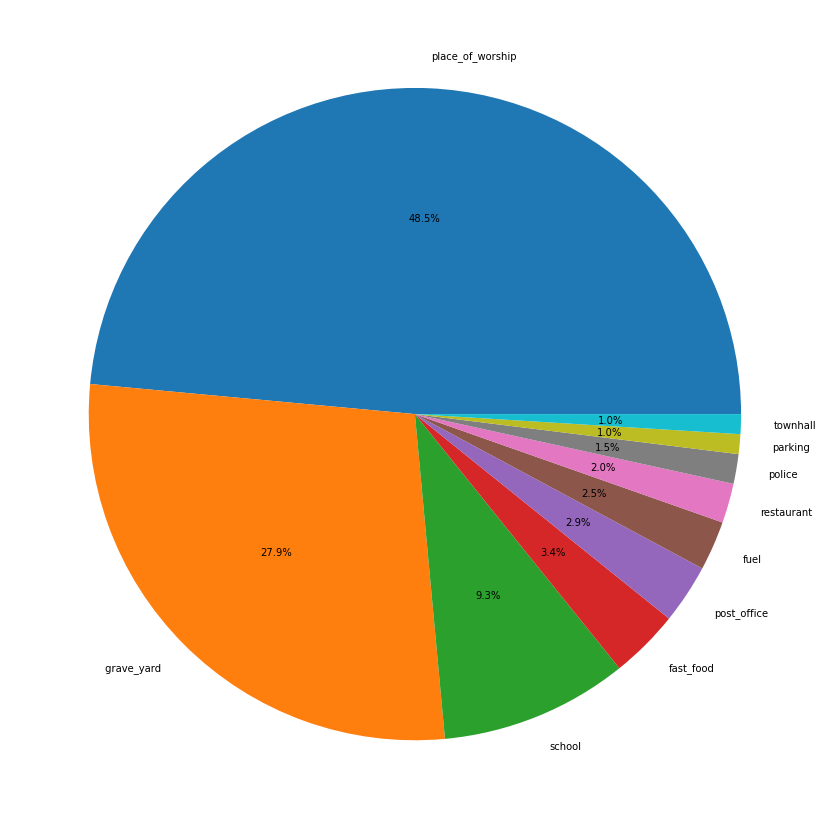

In [18]:
am_type = ["place_of_worship", " grave_yard", "school", "fast_food", "post_office", "fuel", "restaurant", \
          "police", "parking", "townhall"]
am_count = [99, 57, 19, 7, 6, 5, 4, 3, 2, 2]
plt.figure(figsize=(15,15))
plt.pie(am_count, labels=am_type, autopct='%1.1f%%')
plt.show()

This chart shows the lopsided stats on the types of amenities.

## Additonal suggestions

The main issue I have with the data are the fields with multiple values combined with varying punctuation. A road should not have two directions, or three names. It is very hard to analyze the data with simple queries if you have to take these types of anomolies into account. These values should be split into new fields. I would suggest "primary", "secondary", etc.

An example of badly formatted zip codes:

In [20]:
sql = "SELECT * FROM openstreetmap.way_tags \
where way_value like '%:%' \
and way_key like '%zip%';"

cursor = db.cursor()
cursor.execute(sql)
result = cursor.fetchall()
for x in result:
    print(x)

(9403112, 'zip_left', '30705:30711', 'tiger\r')
(9403112, 'zip_right', '30705:30711', 'tiger\r')
(386971671, 'zip_left', '30175:30705', 'tiger\r')
(386971671, 'zip_right', '30175:30705', 'tiger\r')
(432278701, 'zip_left', '30139:30171:30184', 'tiger\r')
(432278701, 'zip_right', '30139:30184', 'tiger\r')
(432460916, 'zip_left', '30139:30171:30184', 'tiger\r')
(432460916, 'zip_right', '30139:30184', 'tiger\r')
(432460917, 'zip_left', '30139:30171:30184', 'tiger\r')
(432460917, 'zip_right', '30139:30184', 'tiger\r')
(447249731, 'zip_left', '30139:30171:30184', 'tiger\r')
(447249731, 'zip_right', '30139:30184', 'tiger\r')
(447249732, 'zip_left', '30139:30171:30184', 'tiger\r')
(447249732, 'zip_right', '30139:30184', 'tiger\r')
(447249733, 'zip_left', '30139:30171:30184', 'tiger\r')
(447249733, 'zip_right', '30139:30184', 'tiger\r')
(447249734, 'zip_left', '30139:30171:30184', 'tiger\r')
(447249734, 'zip_right', '30139:30184', 'tiger\r')
(447250971, 'zip_left', '30139:30171:30184', 'tiger\r

As shown above, there are multiple cases of double or even triple values for the zip code. This makes data analysis more tedious and error prone than it should be. These values need to be split into their own ordered sub tags. This would be comparison and totalization queries much faster.

The main issue with doing this change would be research involved with deciding what zip code should be the primary zip code. An objective qualifier would have to be decided and used. I would suggest percentage of the entity in a certain zip to be the qualifier. However, this might take more time than it is worth. It would really depend on the usage of the data.